In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from PIL import Image
import cv2
import random

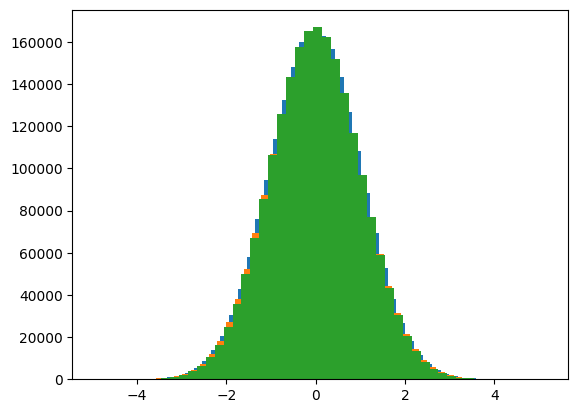

In [2]:
r = np.random.randn(128, 128, 128, 3)
plt.hist(r[..., 0].flatten(), bins=50)
plt.hist(r[..., 1].flatten(), bins=50)
plt.hist(r[..., 2].flatten(), bins=50)
plt.show()

In [3]:
images = glob.glob("/home/student/andrewheschl/Documents/Datasets/ClassificationDataset/preprocessed/Dataset_large_421/fold_0/train/imagesTr/*")
random.shuffle(images)
img = np.stack([cv2.resize(np.load(x)[:, 0:512, 0:512].transpose((1, 2, 0)), (128, 128), interpolation=cv2.INTER_CUBIC) for x in images[0:]], axis=0)

In [5]:
img -= np.min(img)
img /= np.max(img)
img*=255
print(img.min(), img.max())

0.0 255.0


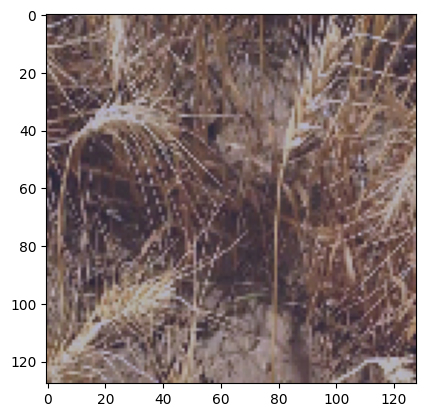

In [6]:
plt.imshow(img[0].astype(np.uint8))

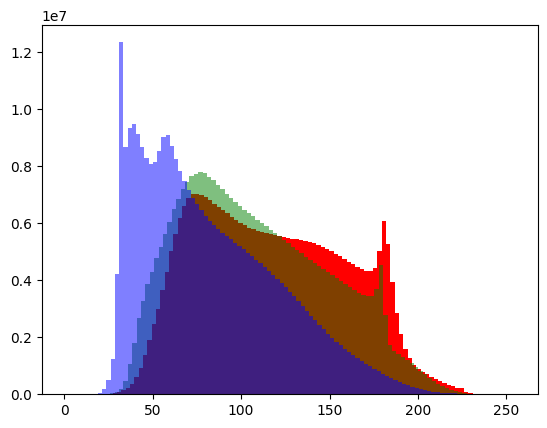

In [7]:

plt.hist(img[:, :, :, 0].flatten(), bins=101, color='r')
plt.hist(img[:, :, :, 1].flatten(), bins=101, color='g', alpha=0.5)
plt.hist(img[:, :, :, 2].flatten(), bins=101, color='b', alpha=0.5)
plt.show()

In [65]:
import pandas as pd
import seaborn as sns
import os

RESULTS_ROOT = os.environ.get("RESULTS_ROOT")

def plot_b(color, alpha=1, epoch=-1, method="concat_gan_slow_lr_v2"):
    data = pd.read_csv(f"{RESULTS_ROOT}/Dataset_large_421/fold_0/{method}/dist/{color.upper()}.csv")
    recent = data.iloc[epoch][f"{method} - generated {str(color).upper()} distribution"]
    recent = eval(recent)
    values = recent["values"]
    bins = recent["bins"]
    print(len(bins), len(values))
    print(len(bins))
    # plot the precomputed values and bins to a histogram using seaborn or matplotlib. sns.histplot(values, bins=bins) is not working properly
    # sns.histplot(values, bins=bins) and neither is plt.hist(values, bins=bins)
    # this is because the values are already binned by wandb
    # so we can use plt.bar to plot the values
    plt.bar(bins[:-1], values, width=np.diff(bins), color=color, alpha=alpha)

def get_histogram(color, epoch, alpha=1, method="concat_gan_slow_lr_v2"):
    data = pd.read_csv(f"{RESULTS_ROOT}/Dataset_large_421/fold_0/{method}/dist/{color.upper()}.csv")
    recent = data.iloc[epoch][f"{method} - generated {str(color).upper()} distribution"]
    recent = eval(recent)
    values = recent["values"]
    bins = recent["bins"]
    return values, bins



65 64
65
65 64
65
65 64
65


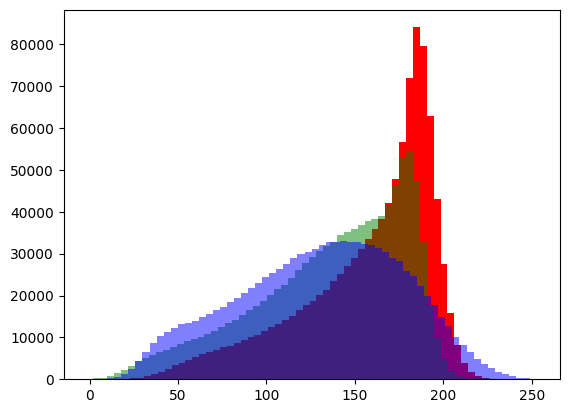

In [66]:
plot_b("r")
plot_b("g", alpha=0.5)
plot_b("b", alpha=0.5)


In [67]:
real_r_hist = np.histogram(img[:, :, :, 0].flatten(), bins=64)
real_g_hist = np.histogram(img[:, :, :, 1].flatten(), bins=64)
real_b_hist = np.histogram(img[:, :, :, 2].flatten(), bins=64)

generated_r_hist = get_histogram('r', -1)
generated_g_hist = get_histogram('g', -1)
generated_b_hist = get_histogram('b', -1)

In [68]:
# kl divergence
def kl_divergence(p, q):
    smooth = 1e-10
    p = p / np.sum(p)
    q = q / np.sum(q)
    return np.sum(p * np.log((p + smooth) / (q + smooth)))

def js_divergence(p, q):
    p = p / np.sum(p)
    q = q / np.sum(q)
    
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [107]:
METHOD_NAME = "concat_gan_slow_lr_v2"

In [108]:
data = pd.read_csv(f"{RESULTS_ROOT}/Dataset_large_421/fold_0/{METHOD_NAME}/dist/{'R'}.csv")

epochs = len(data)
print(epochs)
r_divergences = [js_divergence(real_r_hist[0], get_histogram('r', i, method=METHOD_NAME)[0]) for i in range(epochs)]
g_divergences = [js_divergence(real_g_hist[0], get_histogram('g', i, method=METHOD_NAME)[0]) for i in range(epochs)]
b_divergences = [js_divergence(real_b_hist[0], get_histogram('b', i, method=METHOD_NAME)[0]) for i in range(epochs)]

400


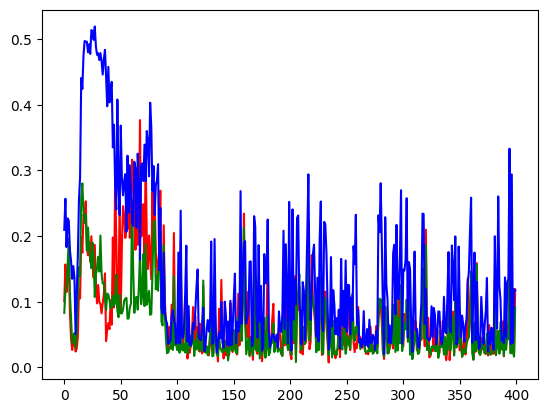

In [109]:
# plot r_divergences
plt.plot(r_divergences, color='r')
plt.plot(g_divergences, color='g')
plt.plot(b_divergences, color='b')
plt.show()

In [110]:
# remove outliers
r_divergences = np.array(r_divergences)
g_divergences = np.array(g_divergences)
b_divergences = np.array(b_divergences)

r_divergences_clean = r_divergences[r_divergences < 0.3]
g_divergences_clean = g_divergences[g_divergences < 0.3]
b_divergences_clean = b_divergences[b_divergences < 0.3]

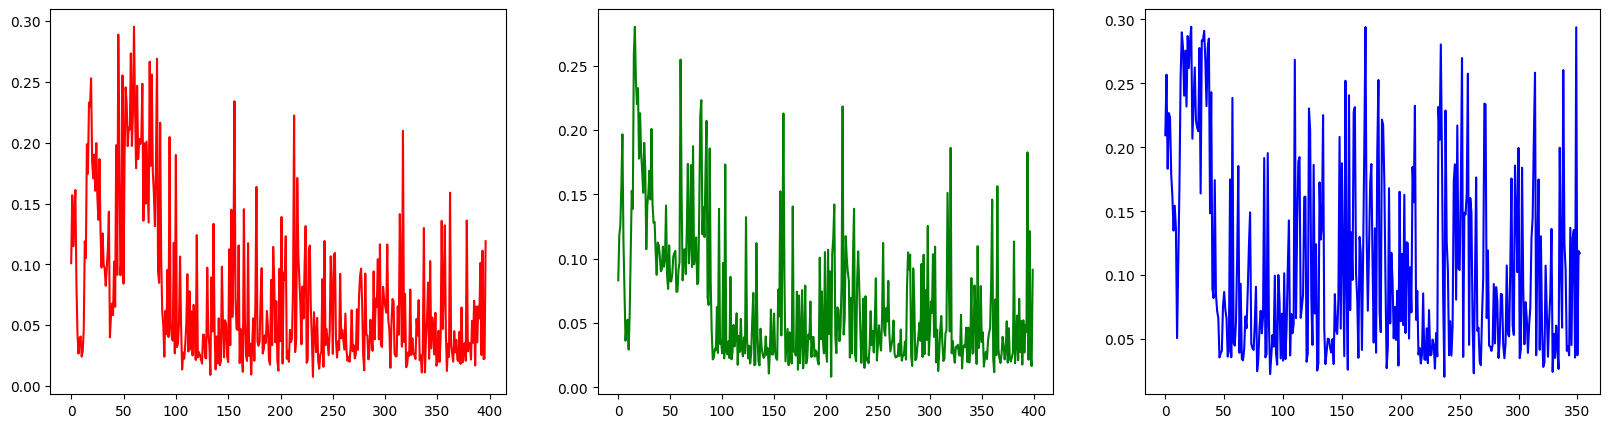

In [111]:
_, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].plot(r_divergences_clean, color='r')
ax[1].plot(g_divergences_clean, color='g')
ax[2].plot(b_divergences_clean, color='b')

In [112]:
# ema of divergences
def ema(data, alpha=0.99):
    ema = [data[0]]
    for i in range(1, len(data)):
        ema.append(alpha * ema[-1] + (1 - alpha) * data[i])
    return ema

r_divergences_ema = ema(r_divergences)
g_divergences_ema = ema(g_divergences)
b_divergences_ema = ema(b_divergences)

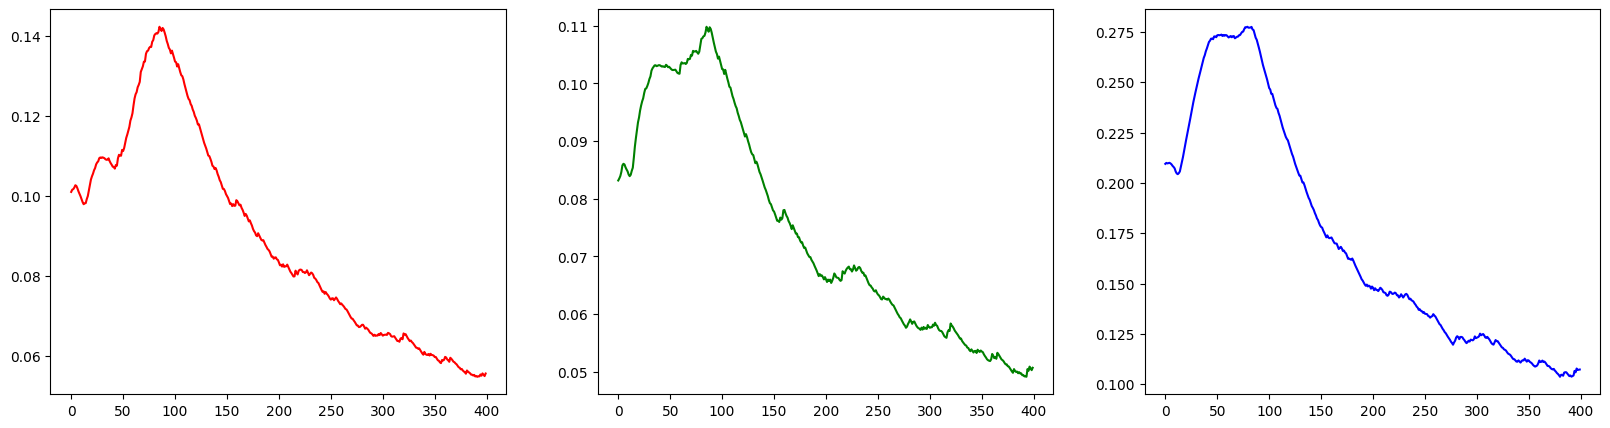

In [113]:
_, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].plot(r_divergences_ema, color='r')
ax[1].plot(g_divergences_ema, color='g')
ax[2].plot(b_divergences_ema, color='b')

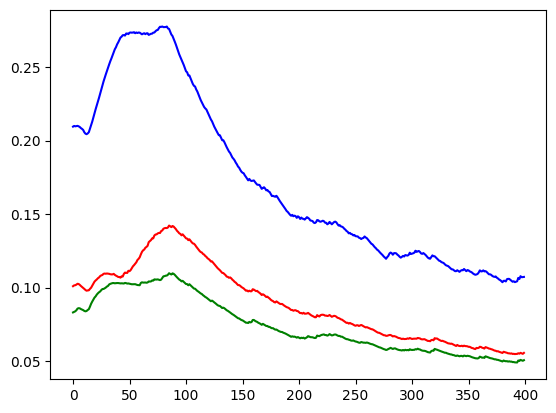

In [114]:
plt.plot(r_divergences_ema, color='r')
plt.plot(g_divergences_ema, color='g')
plt.plot(b_divergences_ema, color='b')
plt.show()

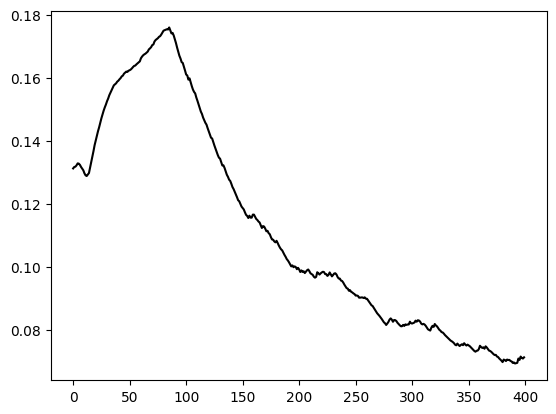

In [115]:
r_divergences_ema = np.array(r_divergences_ema)
g_divergences_ema = np.array(g_divergences_ema)
b_divergences_ema = np.array(b_divergences_ema)

average_of_divergences = (r_divergences_ema + g_divergences_ema + b_divergences_ema) / 3
plt.plot(average_of_divergences, color='black')

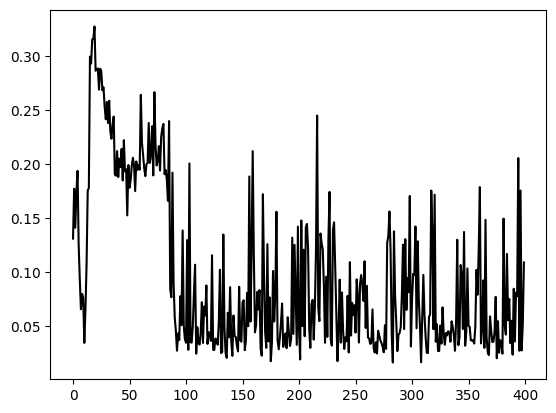

In [116]:
# avergae
r_divergences = np.array(r_divergences)
g_divergences = np.array(g_divergences)
b_divergences = np.array(b_divergences)

average_of_divergences = (r_divergences + g_divergences + b_divergences) / 3
plt.plot(average_of_divergences, color='black')

283
   Step   concat_gan_slow_lr_v2 - generated R distribution
0     2  {"_type":"histogram","values":[4,6,5,18,21,28,...
1     7  {"values":[1,1,0,1,2,8,8,18,32,46,66,82,115,15...
2    12  {"_type":"histogram","values":[2,1,6,9,8,18,27...
3    17  {"_type":"histogram","values":[2,0,6,6,6,24,20...
4    22  {"values":[6,10,15,11,20,12,27,28,30,32,33,47,...
Step                                                                                             1417
concat_gan_slow_lr_v2 - generated R distribution    {"_type":"histogram","values":[70,130,333,753,...
Name: 283, dtype: object
65 64
65
65 64
65
65 64
65


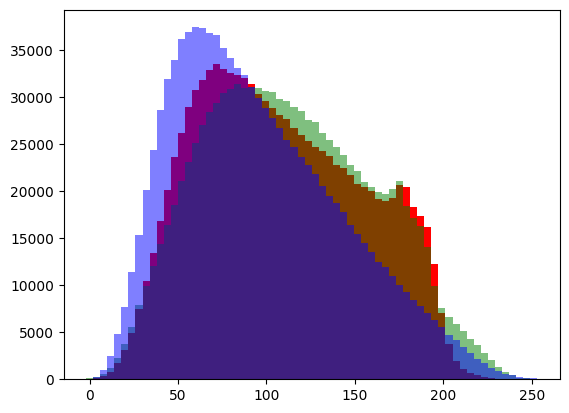

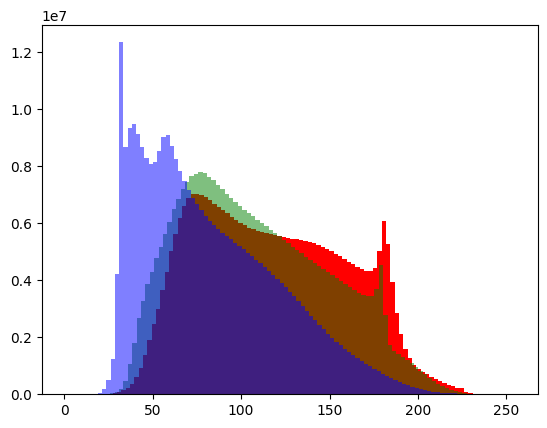

In [117]:
# epoch of minimum average
min_epoch = np.argmin(average_of_divergences[100:])+100
print(min_epoch)
# show this row
print(data.head())
print(data.iloc[min_epoch])
# plot the hisotgrams at this row
plot_b("r", epoch=min_epoch)
plot_b("g", alpha=0.5, epoch=min_epoch)
plot_b("b", alpha=0.5, epoch=min_epoch)
plt.show()

plt.hist(img[:, :, :, 0].flatten(), bins=101, color='r')
plt.hist(img[:, :, :, 1].flatten(), bins=101, color='g', alpha=0.5)
plt.hist(img[:, :, :, 2].flatten(), bins=101, color='b', alpha=0.5)
plt.show()

In [38]:
# best epoch for r
r_divergences = np.array(r_divergences)
min_epoch = np.argmin(r_divergences)
print(min_epoch)
data = pd.read_csv(f"./inference_bins_r.csv")
print(data.iloc[min_epoch])


234
Step                                                                                         1172
shared_encoder_v2 - generated R distribution    {"_type":"histogram","values":[7,19,61,163,413...
Name: 234, dtype: object


In [39]:
# best epoch for g
g_divergences = np.array(g_divergences)
min_epoch = np.argmin(g_divergences)
print(min_epoch)
data = pd.read_csv(f"./inference_bins_g.csv")
print(data.iloc[min_epoch])


205
Step                                                                                         1027
shared_encoder_v2 - generated G distribution    {"values":[215,432,971,1932,3264,4656,6197,763...
Name: 205, dtype: object


In [40]:
# best epoch for b
b_divergences = np.array(b_divergences)
min_epoch = np.argmin(b_divergences)
print(min_epoch)
data = pd.read_csv(f"./inference_bins_b.csv")
print(data.iloc[min_epoch])


283
Step                                                                                         1417
shared_encoder_v2 - generated B distribution    {"values":[300,2009,10426,28887,46265,51090,51...
Name: 283, dtype: object


In [ ]:
print()